<a href="https://colab.research.google.com/github/Ying-Yuan07/TensorFlowLearn/blob/main/LstmTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM model: LstmRNN(
  (lstm): LSTM(1, 16)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)
model.parameters: <bound method Module.parameters of LstmRNN(
  (lstm): LSTM(1, 16)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)>
Epoch: [100/10000], Loss:0.00123
Epoch: [200/10000], Loss:0.00030
Epoch: [300/10000], Loss:0.00024
Epoch: [400/10000], Loss:0.00017
Epoch: [500/10000], Loss:0.00015
Epoch: [600/10000], Loss:0.00014
Epoch: [700/10000], Loss:0.00013
Epoch: [800/10000], Loss:0.00012
Epoch: [900/10000], Loss:0.00012
Epoch: [1000/10000], Loss:0.00011
Epoch: [1100/10000], Loss:0.00013
Epoch: [1200/10000], Loss:0.00011
Epoch: [1300/10000], Loss:0.00010
Epoch: [1400/10000], Loss:0.00010
Epoch [1437/10000], Loss: 0.00010
The loss value is reached


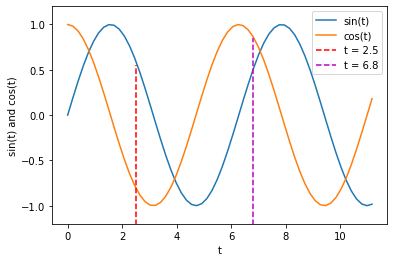

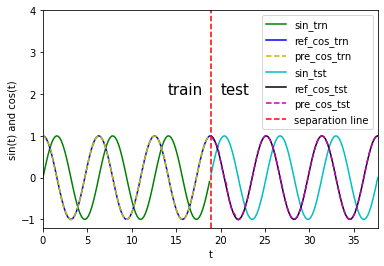

In [2]:
# -*- coding:UTF-8 -*-
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Define LSTM Neural Networks
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # utilize the LSTM model in torch.nn 
        self.forwardCalculation = nn.Linear(hidden_size, output_size)
 
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        x = self.forwardCalculation(x)
        x = x.view(s, b, -1)
        return x

if __name__ == '__main__':
    # create database
    data_len = 200
    t = np.linspace(0, 12*np.pi, data_len)
    sin_t = np.sin(t)
    cos_t = np.cos(t)

    dataset = np.zeros((data_len, 2))
    dataset[:,0] = sin_t
    dataset[:,1] = cos_t
    dataset = dataset.astype('float32')

    # plot part of the original dataset
    plt.figure()
    plt.plot(t[0:60], dataset[0:60,0], label='sin(t)')
    plt.plot(t[0:60], dataset[0:60,1], label = 'cos(t)')
    plt.plot([2.5, 2.5], [-1.3, 0.55], 'r--', label='t = 2.5') # t = 2.5
    plt.plot([6.8, 6.8], [-1.3, 0.85], 'm--', label='t = 6.8') # t = 6.8
    plt.xlabel('t')
    plt.ylim(-1.2, 1.2)
    plt.ylabel('sin(t) and cos(t)')
    plt.legend(loc='upper right')

    # choose dataset for training and testing
    train_data_ratio = 0.5 # Choose 80% of the data for testing
    train_data_len = int(data_len*train_data_ratio)
    train_x = dataset[:train_data_len, 0]
    train_y = dataset[:train_data_len, 1]
    INPUT_FEATURES_NUM = 1
    OUTPUT_FEATURES_NUM = 1
    t_for_training = t[:train_data_len]

    # test_x = train_x
    # test_y = train_y
    test_x = dataset[train_data_len:, 0]
    test_y = dataset[train_data_len:, 1]
    t_for_testing = t[train_data_len:]

    # ----------------- train -------------------
    train_x_tensor = train_x.reshape(-1, 5, INPUT_FEATURES_NUM) # set batch size to 5
    train_y_tensor = train_y.reshape(-1, 5, OUTPUT_FEATURES_NUM) # set batch size to 5
 
    # transfer data to pytorch tensor
    train_x_tensor = torch.from_numpy(train_x_tensor)
    train_y_tensor = torch.from_numpy(train_y_tensor)
    # test_x_tensor = torch.from_numpy(test_x)
 
    lstm_model = LstmRNN(INPUT_FEATURES_NUM, 16, output_size=OUTPUT_FEATURES_NUM, num_layers=1) # 16 hidden units
    print('LSTM model:', lstm_model)
    print('model.parameters:', lstm_model.parameters)
 
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
 
    max_epochs = 10000
    for epoch in range(max_epochs):
        output = lstm_model(train_x_tensor)
        loss = loss_function(output, train_y_tensor)
 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
        if loss.item() < 1e-4:
            print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, max_epochs, loss.item()))
            print("The loss value is reached")
            break
        elif (epoch+1) % 100 == 0:
            print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch+1, max_epochs, loss.item()))
 
    # prediction on training dataset
    predictive_y_for_training = lstm_model(train_x_tensor)
    predictive_y_for_training = predictive_y_for_training.view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    # torch.save(lstm_model.state_dict(), 'model_params.pkl') # save model parameters to files
 
    # ----------------- test -------------------
    # lstm_model.load_state_dict(torch.load('model_params.pkl'))  # load model parameters from files
    lstm_model = lstm_model.eval() # switch to testing model

    # prediction on test dataset
    test_x_tensor = test_x.reshape(-1, 5, INPUT_FEATURES_NUM) # set batch size to 5, the same value with the training set
    test_x_tensor = torch.from_numpy(test_x_tensor)
 
    predictive_y_for_testing = lstm_model(test_x_tensor)
    predictive_y_for_testing = predictive_y_for_testing.view(-1, OUTPUT_FEATURES_NUM).data.numpy()
 
    # ----------------- plot -------------------
    plt.figure()
    plt.plot(t_for_training, train_x, 'g', label='sin_trn')
    plt.plot(t_for_training, train_y, 'b', label='ref_cos_trn')
    plt.plot(t_for_training, predictive_y_for_training, 'y--', label='pre_cos_trn')

    plt.plot(t_for_testing, test_x, 'c', label='sin_tst')
    plt.plot(t_for_testing, test_y, 'k', label='ref_cos_tst')
    plt.plot(t_for_testing, predictive_y_for_testing, 'm--', label='pre_cos_tst')

    plt.plot([t[train_data_len], t[train_data_len]], [-1.2, 4.0], 'r--', label='separation line') # separation line

    plt.xlabel('t')
    plt.ylabel('sin(t) and cos(t)')
    plt.xlim(t[0], t[-1])
    plt.ylim(-1.2, 4)
    plt.legend(loc='upper right')
    plt.text(14, 2, "train", size = 15, alpha = 1.0)
    plt.text(20, 2, "test", size = 15, alpha = 1.0)

    plt.show()